<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Sentiment_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline


In [32]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Demo1 clean.csv to Demo1 clean (1).csv


In [33]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Demo1 clean.csv']))

In [34]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"['experience', 'rancho', 'valencia', 'absolute...",Positive
1,1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"['amazing', 'place', 'everyone', 'extremely', ...",Positive
2,2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"['booked', '3', 'night', 'stay', 'rancho', 'va...",Positive
3,3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"['currently', 'bed', 'writing', 'past', 'hr', ...",Negative
4,4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"['live', 'md', 'aloft', 'home', 'away', 'homew...",Positive


In [35]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [36]:
data.head()


,Unnamed: 0,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"['experience', 'rancho', 'valencia', 'absolute...",1
1,1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"['amazing', 'place', 'everyone', 'extremely', ...",1
2,2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"['booked', '3', 'night', 'stay', 'rancho', 'va...",1
3,3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"['currently', 'bed', 'writing', 'past', 'hr', ...",0
4,4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"['live', 'md', 'aloft', 'home', 'away', 'homew...",1


In [37]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [38]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [39]:
# Checking for missing values
pd.isnull(data).any()



Unnamed: 0    False
Hotel_id      False
Hotel         False
Title          True
Users         False
Reviews        True
Text_Clean     True
Rating        False
tokens        False
Sentiment     False
dtype: bool

In [40]:
#Filing the missing Review with 'na'
data['Reviews'] = data['Reviews'].fillna('').apply(str)
data['Title'] = data['Title'].fillna('').apply(str)
data['Text_Clean'] = data['Text_Clean'].fillna('').apply(str)


In [41]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (9999, 10)
Index(['Unnamed: 0', 'Hotel_id', 'Hotel', 'Title', 'Users', 'Reviews',
       'Text_Clean', 'Rating', 'tokens', 'Sentiment'],
      dtype='object')
No. of unique classes 2


In [42]:
macronum=sorted(set(data['Sentiment']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Sentiment']=data['Sentiment'].apply(fun)

In [43]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Sentiment']:
    labels.append(idx)

In [44]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 20921


In [45]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (9999, 1000)
Shape of Label Tensor: (9999, 2)


In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-19 09:17:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-19 09:17:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-19 09:17:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [23]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [24]:
!ls
!pwd

'Demo1 clean.csv'    glove.6B.200d.txt	 glove.6B.50d.txt   sample_data
 glove.6B.100d.txt   glove.6B.300d.txt	 glove.6B.zip
/content


In [46]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [47]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [48]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [49]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2092200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 2,253,402
Trainable params: 2,253,402
Non-trainable params: 0
_________________________________________________________________


In [50]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=5, batch_size=32,callbacks=[cp])

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.4666 - acc: 0.7830
Epoch 00001: val_acc improved from -inf to 0.82291, saving model to model_rnn.hdf5
250/250 [==============================] - 381s 2s/step - loss: 0.4666 - acc: 0.7830 - val_loss: 0.4029 - val_acc: 0.8229
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.3726 - acc: 0.8359
Epoch 00002: val_acc improved from 0.82291 to 0.83442, saving model to model_rnn.hdf5
250/250 [==============================] - 377s 2s/step - loss: 0.3726 - acc: 0.8359 - val_loss: 0.3601 - val_acc: 0.8344
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.3187 - acc: 0.8634
Epoch 00003: val_acc improved from 0.83442 to 0.85393, saving model to model_rnn.hdf5
250/250 [==============================] - 381s 2s/step - loss: 0.3187 - acc: 0.8634 - val_loss: 0.3440 - val_acc: 0.8539
Epoch 4/5
250/250 [==============================] - ETA: 0s - loss: 0.2812 - acc: 0.8845
Epoch 00004: val_ac

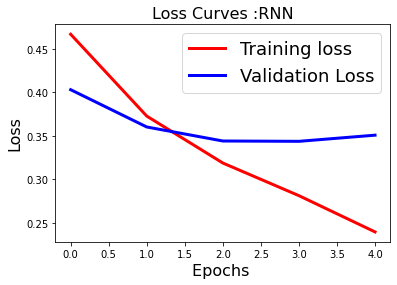

In [51]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

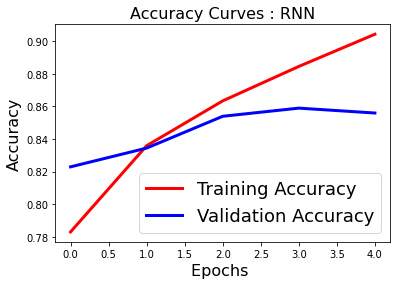

In [52]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

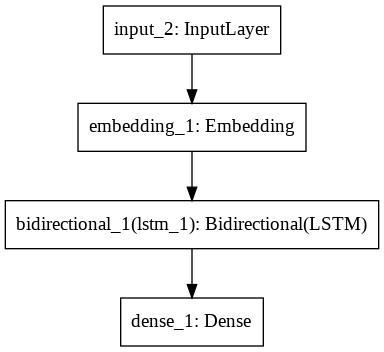

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='rnn_model.png')